In [36]:
import os
import pathlib
from glob import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pickle

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import *
from tensorflow.python.saved_model import signature_constants

import mlflow
from mlflow.tracking import MlflowClient
from mlflow.exceptions import MlflowException
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec

from prefect import flow, task
from prefect.task_runners import SequentialTaskRunner

print(f'Pandas:{pd.__version__}, Numpy:{np.__version__}, Tensorflow:{tf.__version__}')
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print('Device:', tf.config.list_physical_devices('GPU'))
print("----Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Pandas:1.3.4, Numpy:1.21.4, Tensorflow:2.11.0
Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
----Num GPUs Available:  1


In [37]:
def mlflow_setup():
    MLFLOW_TRACKING_URI ="sqlite:////home/pmspraju/tracking-server/mlflow.db" 
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

    return client

In [38]:
@task
def create_mlflow_experiment(experiment_name):
    try:
        experiment_id = mlflow.create_experiment(
            experiment_name,
            #artifact_location=Path.cwd().joinpath("mlruns").as_uri(),
            artifact_location='//home/pmspraju/tracking-server/mlruns/',
            tags={"version": "v1", "priority": "P1"},
        )
    except Exception as MlflowException:
        print(f"Experiment exists")
        experiment= mlflow.set_experiment(experiment_name)
        # Examine the experiment details.
        print("Experiment_id: {}".format(experiment.experiment_id))
        print("Name: {}".format(experiment.name))
        print("Artifact Location: {}".format(experiment.artifact_location))
        print("Tags: {}".format(experiment.tags))
        print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
        print("Last Updated timestamp: {}".format(experiment.last_update_time))

In [39]:
# Resize an image based on a scale factor. Take in to consideration that it receives an image represented as Numpy array.
def resize_image(image_array, factor):
    original_image = Image.fromarray(image_array)
    new_size = np.array(original_image.size) * factor
    new_size = new_size.astype(np.int32)
    new_size = tuple(new_size)

    resized = original_image.resize(new_size)
    resized = img_to_array(resized)
    resized = resized.astype(np.uint8)

    return resized

In [41]:
# Tightly crop an image. We need the image to fit nicely when we apply a sliding window to extract patches later. 
# SCALE is the actor we want the network to learn how to enlarge images by
def tight_crop_image(image, scale):
    height, width = image.shape[:2]
    width -= int(width % scale)
    height -= int(height % scale)

    return image[:height, :width]

In [42]:
# Reduce resolution of an imae by downsizing and then upsizing 
def downsize_upsize_image(image, scale):
    scaled = resize_image(image, 1.0 / scale)
    scaled = resize_image(scaled, scale / 1.0)

    return scaled

In [43]:
# Crop patches from input images. input_dim is the height&width of the images that is input to the network
def crop_input(image, x, y, input_dim):
    x_slice = slice(x, x + input_dim)
    y_slice = slice(y, y + input_dim)

    return image[y_slice, x_slice]

In [44]:
# Crop patches of output images. label_size is the height&width of the images output by the network. 
# pad is the number of pixels used as padding to ensure we are cropping the roi accurately
def crop_output(image, x, y, label_size, pad):
    y_slice = slice(y + pad, y + pad + label_size)
    x_slice = slice(x + pad, x + pad + label_size)
    #print(x, y , x_slice, y_slice)

    return image[y_slice, x_slice]


In [45]:
# method to prepare data
#@task
def prepare_data(path):
    SEED = 999
    SUBSET_SIZE = 100 #1500
    SCALE = 2.0
    INPUT_DIM = 33
    LABEL_SIZE = 21
    PAD = int((INPUT_DIM - LABEL_SIZE) / SCALE)
    STRIDE = 14
    
    np.random.seed(SEED)
    pattern = (path / 'images' / '*.png')
    file_patterns = str(pattern)
    dataset_paths = [*glob(file_patterns)]
    
    dataset_paths = np.random.choice(dataset_paths, SUBSET_SIZE)

    data = []; labels = []; cnt = 0

    for image_path in dataset_paths:
        image = load_img(image_path)
        image = img_to_array(image)
        image = image.astype(np.uint8); #Image.fromarray(image).show()
        image = tight_crop_image(image, SCALE); #Image.fromarray(image).show()
        scaled = downsize_upsize_image(image, SCALE); #Image.fromarray(scaled).show()

        height, width = image.shape[:2]
        #print(f'height:{height},width:{width}')
        
        for y in range(0, height - INPUT_DIM + 1, STRIDE):
            for x in range(0, width - INPUT_DIM + 1, STRIDE):
                crop = crop_input(scaled, x, y, INPUT_DIM); #Image.fromarray(crop).show()
                target = crop_output(image, x, y, LABEL_SIZE, PAD);#Image.fromarray(target).show()
                
                #cnt = cnt + 1
                
                data.append(crop)#data.append(np.array(crop).flatten()) #use np.reshape(fi,(33,33,3)) to read        
                labels.append(target)#labels.append(np.array(target).flatten());#use np.reshape(fi,(33,33,3)) to read  

                #fname = f'train/images/image_{y}_{x}.png' 
                #Image.fromarray(crop).save(os.path.join(path,fname))   

                #fname = f'train/labels/label_{y}_{x}.png'              
                #Image.fromarray(target).save(os.path.join(path,fname)) 
                #break
            #break
        #break
    #print(cnt)    
    return [data, labels]
    #pd.DataFrame({'image': data, 'label': labels})


In [10]:
# # Test data
# path = pathlib.Path('/mnt/c/Users/pmspr/Documents/Machine Learning/Courses/Tensorflow Cert/Data/dogscats')
# [data, labels] = prepare_data(path)
# print(f'shape:{np.array(labels).shape}')
# print(f'shape:{np.array(data).shape}')
# labels = tf.convert_to_tensor(labels, np.int32)
# print(labels.shape)

shape:(67477, 21, 21, 3)
shape:(67477, 33, 33, 3)
(67477, 21, 21, 3)


2023-03-20 05:03:15.284200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-20 05:03:15.284296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-72LU0U0G): /proc/driver/nvidia/version does not exist
2023-03-20 05:03:15.286964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [46]:
@task #- task cannot be called inside another task
def build_model(height, width, depth):
    input = Input(shape=(height, width, depth))

    x = Conv2D(filters=64, 
               kernel_size=(9,9),
               kernel_initializer='he_normal'
               ) (input)
    
    x = ReLU()(x)

    x = Conv2D(filters=32, 
               kernel_size=(1,1),
               kernel_initializer='he_normal'
                ) (x)

    x = ReLU()(x)

    output = Conv2D(filters=depth, 
                    kernel_size=(5,5),
                    kernel_initializer='he_normal'
                    ) (x)

    return Model(input, output)


In [54]:
@task
def train_model(path, dim,  data, labels, model):
    data = tf.convert_to_tensor(data, np.int32)
    labels = tf.convert_to_tensor(labels, np.int32)
    print(f'Data shape:{data.shape}, Labels shape"{labels.shape}')

    EPOCHS = 15
    optimizer = Adam(learning_rate=1e-3, beta_1=1e-3 / EPOCHS)
    
    model.compile(loss='mse', optimizer=optimizer)
    BATCH_SIZE = 64
    
    model.fit(data, labels, batch_size=BATCH_SIZE, epochs = EPOCHS)

    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)

    input_schema = Schema([
                            TensorSpec(np.dtype(np.uint8), (-1, dim, dim, 3)),
                            ])
    output_schema = Schema([TensorSpec(np.dtype(np.uint8), (-1, 21, 21, 3))])
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)


    mlflow.tensorflow.log_model(model=model,signature=signature,
                                artifact_path="tf-models")

    # write model summary
    summary = []
    model.summary(print_fn=summary.append)
    summary = "\n".join(summary)
    summary_path = os.path.join(path, "model_summary.txt")
    with open(summary_path, "w") as f:
        f.write(summary)
    mlflow.log_artifact(summary_path)
    os.remove(summary_path)

    # write model as json file
    model_json_path = os.path.join(path, "model.json")
    with open(model_json_path, "w") as f:
        f.write(model.to_json())
    mlflow.log_artifact(model_json_path)
    os.remove(model_json_path)

    return model

In [55]:
@flow(task_runner=SequentialTaskRunner())
def main():
    path = pathlib.Path('/mnt/c/Users/pmspr/Documents/Machine Learning/Courses/Tensorflow Cert/Data/dogscats')
    experiment_name = 'IMAGE-RESOLUTION'
    dim = 33
    client = mlflow_setup()
    create_mlflow_experiment(experiment_name)
    [data, labels] = prepare_data(path)
    model = build_model(dim, dim, 3)

    with mlflow.start_run() as run:
        print("MLflow:")
        print("  run_id:",run.info.run_id)
        print("  experiment_id:",run.info.experiment_id)
        mlflow.set_tag("version.mlflow", mlflow.__version__)
        mlflow.set_tag("version.tensorflow", tf.__version__)
        trained_model = train_model(path, dim, data, labels, model)
    
    return trained_model

    

In [56]:
if __name__ == "__main__":
    trained_model = main()

12:43:17.069 | INFO    | prefect.engine - Created flow run 'masterful-panther' for flow 'main'
12:43:17.070 | INFO    | Flow run 'masterful-panther' - Using task runner 'SequentialTaskRunner'
12:43:17.081 | WARNING | Flow run 'masterful-panther' - No default storage is configured on the server. Results from this flow run will be stored in a temporary directory in its runtime environment.
12:43:17.150 | INFO    | Flow run 'masterful-panther' - Created task run 'create_mlflow_experiment-863ae521-1' for task 'create_mlflow_experiment'
12:43:17.248 | INFO    | Task run 'create_mlflow_experiment-863ae521-1' - Finished in state Completed()


Experiment exists
Experiment_id: 3
Name: IMAGE-RESOLUTION
Artifact Location: //home/pmspraju/tracking-server/mlruns/
Tags: {'version': 'v1', 'priority': 'P1'}
Lifecycle_stage: active
Last Updated timestamp: 1674755884516


12:43:19.391 | INFO    | Flow run 'masterful-panther' - Created task run 'build_model-074892a9-1' for task 'build_model'


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......input_layer
.........vars
......re_lu
.........vars
......re_lu_1
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-03-25 12:43:19           64
config.json                                    2023-03-25 12:43:19         3016
variables.h5                                   2023-03-25 12:43:19        98080


12:43:19.523 | INFO    | Task run 'build_model-074892a9-1' - Finished in state Completed()


MLflow:
  run_id: bab2247872be47dabb6ed391b070fadd
  experiment_id: 3


12:43:25.340 | INFO    | Flow run 'masterful-panther' - Created task run 'train_model-7c866860-0' for task 'train_model'
--- Orion logging error ---
The log worker encountered a fatal error.
Traceback (most recent call last):
  File "/home/pmspraju/.local/share/virtualenvs/imageResolution-c2hlZ-SW/lib/python3.9/site-packages/prefect/logging/handlers.py", line 83, in _send_logs_loop
    anyio.run(self.send_logs)
  File "/home/pmspraju/.local/share/virtualenvs/imageResolution-c2hlZ-SW/lib/python3.9/site-packages/anyio/_core/_eventloop.py", line 70, in run
    return asynclib.run(func, *args, **backend_options)
  File "/home/pmspraju/.local/share/virtualenvs/imageResolution-c2hlZ-SW/lib/python3.9/site-packages/anyio/_backends/_asyncio.py", line 292, in run
    return native_run(wrapper(), debug=debug)
  File "/home/pmspraju/anaconda3/lib/python3.9/asyncio/runners.py", line 47, in run
    _cancel_all_tasks(loop)
  File "/home/pmspraju/anaconda3/lib/python3.9/asyncio/runners.py", line 56, i

Data shape:(67477, 33, 33, 3), Labels shape"(67477, 21, 21, 3)
Epoch 1/15
1055/1055 [==============================] - 12s 10ms/step - loss: 1073.6105
Epoch 2/15
1055/1055 [==============================] - 11s 10ms/step - loss: 163.0876
Epoch 3/15
1055/1055 [==============================] - 11s 10ms/step - loss: 153.5426
Epoch 4/15
1055/1055 [==============================] - 11s 10ms/step - loss: 204.3847
Epoch 5/15
1055/1055 [==============================] - 11s 10ms/step - loss: 190.2274
Epoch 6/15
1055/1055 [==============================] - 11s 11ms/step - loss: 198.0505
Epoch 7/15
1055/1055 [==============================] - 11s 11ms/step - loss: 189.2880
Epoch 8/15
1055/1055 [==============================] - 11s 11ms/step - loss: 165.3889
Epoch 9/15
1055/1055 [==============================] - 12s 11ms/step - loss: 1467.4858
Epoch 10/15
1055/1055 [==============================] - 12s 12ms/step - loss: 162.3171
Epoch 11/15
1055/1055 [==============================] - 12s 12m

12:48:00.291 | WARNING | absl - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tmp/tmpp8gf_8n8/model/data/model/assets


12:48:00.522 | INFO    | tensorflow - Assets written to: /tmp/tmpp8gf_8n8/model/data/model/assets


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......input_layer
.........vars
......re_lu
.........vars
......re_lu_1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-03-25 12:48:06           64
config.json                                    2023-03-25 12:48:06         3641
variables.h5                                   2023-03-25 12:48:06       268384


12:48:06.741 | INFO    | Task run 'train_model-7c866860-0' - Finished in state Completed()
12:48:06.850 | INFO    | Flow run 'masterful-panther' - Finished in state Completed('All states completed.')


In [75]:
!jupyter nbconvert --to script imageResolution.ipynb

[NbConvertApp] Converting notebook imageResolution.ipynb to script
[NbConvertApp] Writing 6499 bytes to imageResolution.py


In [57]:
def predict_image(image_path, loaded_model):
    SEED = 999
    SUBSET_SIZE = 100 #1500
    SCALE = 2.0
    INPUT_DIM = 33
    LABEL_SIZE = 21
    PAD = int((INPUT_DIM - LABEL_SIZE) / SCALE)
    STRIDE = 14

    image = load_img(image_path)
    image = img_to_array(image)
    image = image.astype(np.uint8); #Image.fromarray(image).show()
    image = tight_crop_image(image, SCALE); #Image.fromarray(image).show()
    scaled = downsize_upsize_image(image, SCALE); #Image.fromarray(scaled).show()

    output = np.zeros(scaled.shape)
    height, width = output.shape[:2]
    #print(f'height:{height},width:{width}')
    
    for y in range(0, height - INPUT_DIM + 1, LABEL_SIZE):
        for x in range(0, width - INPUT_DIM + 1, LABEL_SIZE):
            crop = crop_input(scaled, x, y, INPUT_DIM); #Image.fromarray(crop).show(); 
            image_batch = np.expand_dims(crop, axis=0)
            prediction = loaded_model.predict(image_batch)
            new_shape = (LABEL_SIZE, LABEL_SIZE, 3)
            prediction = prediction.reshape(new_shape); #Image.fromarray(prediction.astype(np.uint8)).show() #print(prediction.astype(np.int32)) 
            
            output_y_slice = slice(y + PAD, y + PAD + LABEL_SIZE)
            output_x_slice = slice(x + PAD, x + PAD + LABEL_SIZE)
            output[output_y_slice, output_x_slice] = prediction
            
    return [image, output]
    #pd.DataFrame({'image': data, 'label': labels})


/home/pmspraju/.local/share/virtualenvs/imageResolution-c2hlZ-SW/lib/python3.9/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


1/1 [==============================] - 0s 17ms/step


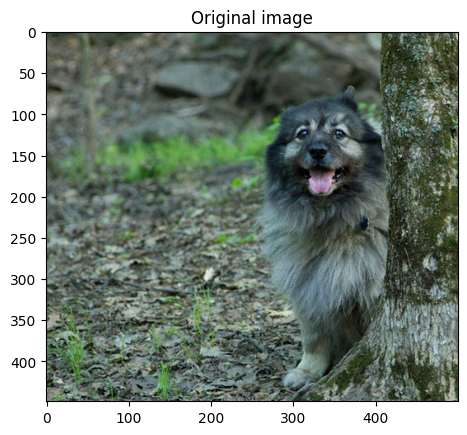

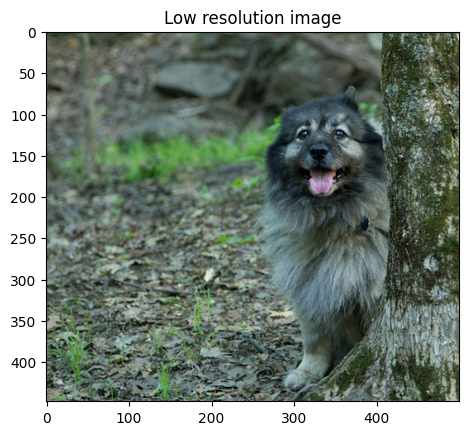

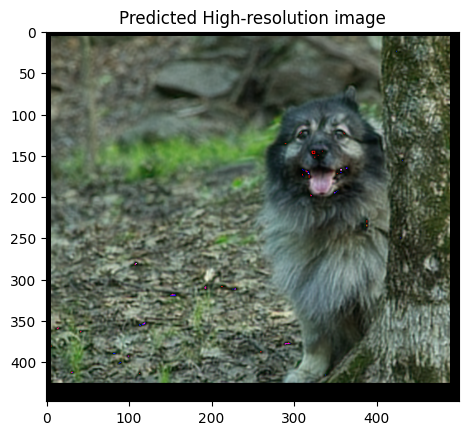

In [53]:
# Predcit the result
import mlflow
mlflow_setup()
#logged_model = 'runs:/ae44f6f340054604971d532ac4e3a550/tf-models' #1 epoch
#logged_model = 'runs:/67da364e0bcf4f389b098d3a8b1e2ef4/tf-models' #12 epochs
logged_model = 'runs:/bab2247872be47dabb6ed391b070fadd/tf-models'
#logged_model = 'runs:/67a8ea212b834eb493aa4d4955126cbb/tf-models' #25 epochs

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
path = pathlib.Path('/mnt/c/Users/pmspr/Documents/Machine Learning/Courses/Tensorflow Cert/Data/dogscats')
pattern = (path / 'images' / '*.png')
file_patterns = str(pattern)
dataset_paths = [*glob(file_patterns)]

image_path = np.random.choice(dataset_paths, 1)
[low_res_image, prediction] = predict_image(image_path[0], loaded_model)

original = load_img(image_path[0])
original = img_to_array(original)
original = original.astype(np.uint8);
prediction = prediction.astype(np.uint8);

plt.title('Original image')
plt.imshow(original)
plt.show()

plt.title('Low resolution image')
plt.imshow(low_res_image)
plt.show()

plt.title('Predicted High-resolution image')
plt.imshow(prediction)
plt.show()


In [ ]:
# path = pathlib.Path('/mnt/c/Users/pmspr/Documents/Machine Learning/Courses/Tensorflow Cert/Data/dogscats')
# df = prepare_data(path)
# with open(os.path.join(path,'train.txt'), 'wb') as fp:
#     pickle.dump(df[0], fp, pickle.HIGHEST_PROTOCOL)
#np.savetxt(os.path.join(path,'train.txt'), df.values, fmt='%d')
# with open(os.path.join(path,'train.txt'), 'a') as f:
#     dfAsString = df.to_string(header=False, index=False)
#     f.write(dfAsString)